In [201]:
import pandas as pd
import numpy as np
import os
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

os.chdir("/home/william/Desktop")

In [202]:
datosTicTacToe = pd.read_csv("tic-tac-toe.csv")
datosTicTacToePosiblesResultados = list(set(datosTicTacToe.iloc[:, -1]))

In [203]:
class PrediccionBase:
    def __init__(self, datos):
        self.__datos = self.cleaning(datos)
        self.__precisionGlobal = 0
        self.__error_global = 0
        self.__verdaderosNegativos = 0
        self.__falsosPositivos = 0
        self.__falsosNegativos = 0
        self.__verdaderosPositivos = 0
        self.__reporte = 0
        self.__precision_category = 0

    @property
    def datos(self):
        return self.__datos

    @property
    def reporte(self):
        return self.__reporte

    def cleaning(self, datos):
        datos = datos.replace({'x': 0, 'o': 1, 'b': 2})
        return datos

    def entrenamiento(self):
        pass

    def generacionReporte(self, nombreDelModelo):
        dict = {
                "Modelo": [nombreDelModelo],
                "Precision Global": [self.__precisionGlobal],
                "Error Global": [self.__error_global],
                "Verdaderos Positivos": [self.__verdaderosPositivos],
                "Verdaderos Negativos": [self.__verdaderosNegativos],
                "Falsos Negativos": [self.__falsosNegativos],
                "Falsos Positivos": [self.__falsosPositivos]}
        self.__reporte = pd.DataFrame(dict).join(self.__precision_category)

    def analsis(self, MC, modelo):
        self.__verdaderosNegativos, self.__falsosPositivos, self.__falsosNegativos, self.__verdaderosPositivos = MC.ravel()
        self.__precisionGlobal = np.sum(MC.diagonal()) / np.sum(MC)
        self.__error_global = 1 - self.__precisionGlobal
        self.__precision_category = pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).T
        self.__precision_category.columns = ["Precision Positiva (PP)", "Precision Negativa (PN)"]
        self.generacionReporte(modelo)
        return {"Matriz de Confusión": MC,
                "Precisión Global": self.__precisionGlobal,
                "Error Global": self.__error_global,
                "Precisión por categoría": self.__precision_category}


class PrediccionKNeighbors(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)

    def entrenamiento(self, nucleo="auto", n_neighbors=3,  train_size=0.80):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        instancia_knn = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=nucleo)
        instancia_knn.fit(X_train, y_train)
        prediccion = instancia_knn.predict(X_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "KNeighbors")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))


class PrediccionArbolBinario(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None

    def graficar(self):
        datos_plotear = export_graphviz(self.__instancia, out_file=None,class_names=list(set(self.datos.iloc[:, -1])),
                feature_names=list(self.datos.iloc[:, :-1].columns.values), filled=True)
        grafico = graphviz.Source(datos_plotear)
        return grafico

    def entrenamiento(self, train_size=0.80):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia = DecisionTreeClassifier()
        self.__instancia.fit(x_train, y_train)
        prediccion = self.__instancia.predict(x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "Arbol de Decisiones")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))


<div>
    <p>Esto seria el analisis del Arbol binario</p>
</div>

In [204]:
prediccionArbol = PrediccionArbolBinario(datos=datosTicTacToe)
prediccionArbol.entrenamiento()


Matriz de Confusión:
[[ 56  18]
 [  4 114]]

Precisión Global:
0.8854166666666666

Error Global:
0.11458333333333337

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.756757                 0.966102


<div>
    <p>Esto seria el analisis del  KNeighbors</p>
</div>

In [205]:
prediccionKNeighbors = PrediccionKNeighbors(datos=datosTicTacToe)
prediccionKNeighbors.entrenamiento()


Matriz de Confusión:
[[ 46  28]
 [  1 117]]

Precisión Global:
0.8489583333333334

Error Global:
0.15104166666666663

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.621622                 0.991525


<div>
    <p>De acuerdo con el proximo reporte el mejor modelo seria el de Arboles de decision, por que tiene mas preciosion global, ademas de menos error global, y la precision positiva es superior en 0,17 unidades.</p>
    <p>En general basicamente es superior en todos los aspectos exepto en la preicision negativa, en este aspecto es inferior pero por muy poco, pero considero que no es tanto para ganarle al de los Arboles de decision</p>
</div>

In [206]:
reporteFinal = pd.concat([prediccionKNeighbors.reporte, prediccionArbol.reporte])
reporteFinal

,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,KNeighbors,0.848958,0.151042,117,46,1,28,0.621622,0.991525
0,Arbol de Decisiones,0.885417,0.114583,114,56,4,18,0.756757,0.966102


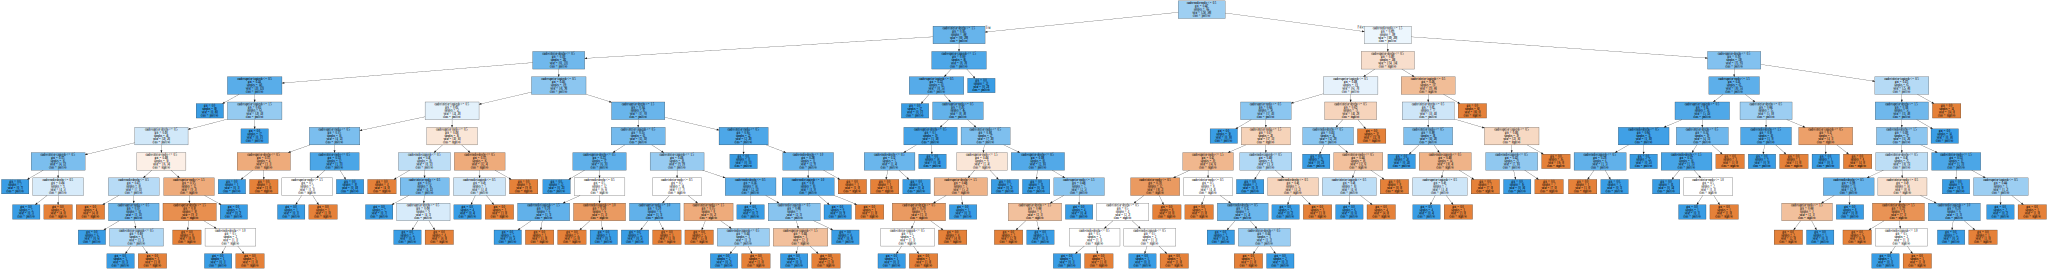

In [207]:
prediccionArbol.graficar()

In [208]:
datosWine = pd.read_csv("wine.csv")
datosWine

,fija.acidez,volatil.acidez,citrica.acidez,residual.azucar,cloruros,libre.sulfuro.dioxido,total.sulfuro.dioxido,densidad,pH,sulfitos,alcohol,calidad,tipo
0,6.2,0.30,0.21,1.1,0.032,31.0,111.0,0.98890,2.97,0.42,12.2,6,blanco
1,6.6,0.61,0.01,1.9,0.080,8.0,25.0,0.99746,3.69,0.73,10.5,5,tinto
2,6.4,0.32,0.23,16.2,0.055,36.0,176.0,0.99860,3.26,0.54,9.1,5,blanco
3,7.0,0.22,0.29,8.9,0.050,24.0,90.0,0.99556,3.29,0.46,9.8,6,blanco
4,6.4,0.43,0.27,1.1,0.054,5.0,110.0,0.99390,3.24,0.52,9.1,4,blanco
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,blanco
6493,6.4,0.26,0.43,12.6,0.033,64.0,230.0,0.99740,3.08,0.38,8.9,5,blanco
6494,6.2,0.25,0.48,10.0,0.044,78.0,240.0,0.99655,3.25,0.47,9.5,6,blanco
6495,7.2,0.60,0.20,9.9,0.070,21.0,174.0,0.99710,3.03,0.54,9.1,5,blanco


In [211]:
prediccionArbolWine = PrediccionArbolBinario(datosWine)
prediccionArbolWine.entrenamiento()
prediccionArbolWine.reporte


Matriz de Confusión:
[[975   2]
 [ 10 313]]

Precisión Global:
0.9907692307692307

Error Global:
0.009230769230769265

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.997953                  0.96904


,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Arbol de Decisiones,0.990769,0.009231,313,975,10,2,0.997953,0.96904


In [214]:
prediccionKNeighborsWine = PrediccionKNeighbors(datosWine)
prediccionKNeighborsWine.entrenamiento()
prediccionKNeighborsWine.reporte


reporteFinal = pd.concat([prediccionKNeighborsWine.reporte, prediccionArbolWine.reporte])
reporteFinal


Matriz de Confusión:
[[941  36]
 [ 51 272]]

Precisión Global:
0.933076923076923

Error Global:
0.06692307692307697

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.963153                 0.842105


,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,KNeighbors,0.933077,0.066923,272,941,51,36,0.963153,0.842105
0,Arbol de Decisiones,0.990769,0.009231,313,975,10,2,0.997953,0.969040


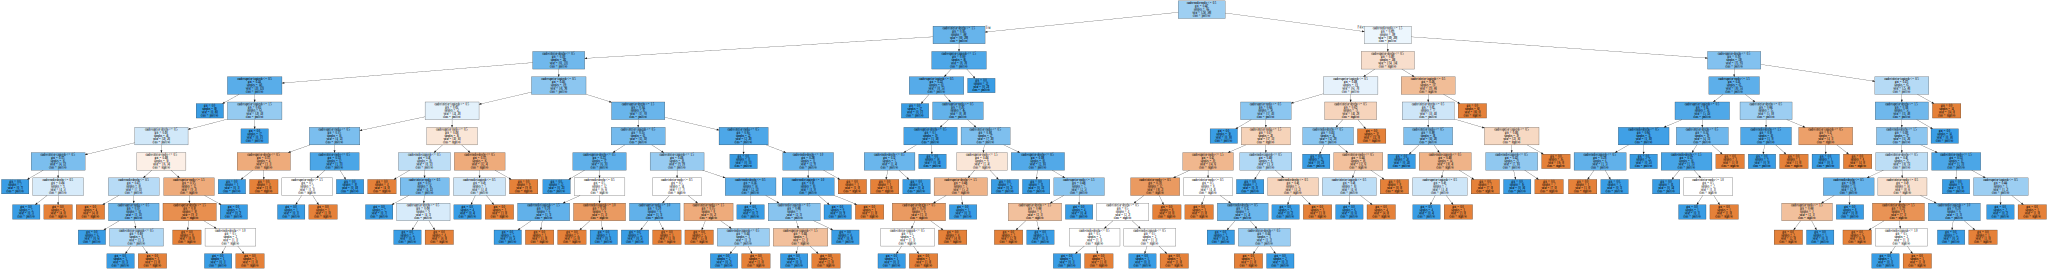

In [212]:
prediccionArbol.graficar()